In [1]:
import os
import datetime
import tensorflow as tf

print(tf.__version__)

2024-08-12 10:46:35.937712: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-12 10:46:35.947089: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-12 10:46:35.961042: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-12 10:46:35.961067: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-12 10:46:35.969798: I tensorflow/core/platform/cpu_feature_gua

2.16.2


In [2]:
tf.config.list_physical_devices('GPU')

2024-08-12 10:46:37.041796: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-12 10:46:37.041860: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-12 10:46:37.060615: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-12 10:46:37.060650: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-12 10:46:37.060667: I external/local_xla/xla/stream_executor

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
# Make directory to log the artifacts
os.makedirs(os.path.join(".", "artifacts", "logs" ), exist_ok=True)

In [4]:
gpus = tf.config.experimental.list_physical_devices("GPU")

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [5]:
#  853*853  ==> 727,609
# 256* 256 ==> 65,536

batch_size = 64
image_height = 128
image_width = 128


In [6]:
DATA_PATH = "/home/forvest/projects/mahdi_amin/vision/classification/rice/data"

data = tf.keras.utils.image_dataset_from_directory(directory=DATA_PATH, 
                                                   batch_size=batch_size, 
                                                   labels = 'inferred',
                                                   label_mode = "int",
                                                   image_size=(image_height, image_width),
                                                   shuffle=True,
                                                   seed=123)

num_classes = len(data.class_names)

Found 4730 files belonging to 20 classes.


2024-08-12 10:46:38.303246: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-12 10:46:38.303298: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-12 10:46:38.303314: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-12 10:46:38.303325: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-12 10:46:38.303335: I external/local_xla/xla/stream_executor

In [7]:
# data = data.map(lambda x, y: (x/255, y))

In [8]:
# Calculate dataset sizes
total_size = len(data)
train_size = int(total_size * 0.7)  # 70% for training
valid_size = int(total_size * 0.15)  # 15% for validation
test_size = total_size - train_size - valid_size  # Remaining for testing

train = data.take(train_size)
valid = data.skip(train_size).take(valid_size)
test = data.skip(train_size+valid_size).take(test_size)

# Verify splits
print(f"Train dataset size: {train_size}")
print(f"Validation dataset size: {valid_size}")
print(f"Test dataset size: {test_size}")

Train dataset size: 51
Validation dataset size: 14
Test dataset size: 9


In [9]:
inputs = tf.keras.Input(shape=(image_height, image_width, 3), name="input")
HL = tf.keras.layers.Rescaling(1/255)(inputs)
HL = tf.keras.layers.RandomFlip(mode="vertical")(HL)
HL = tf.keras.layers.RandomFlip(mode="horizontal" )(HL)
HL = tf.keras.layers.RandomContrast( factor=0.1 )(HL)

HL = tf.keras.layers.Conv2D(filters=16, 
                            kernel_size=5, 
                            padding="valid")(HL)
HL = tf.keras.layers.BatchNormalization()(HL) 
HL = tf.keras.layers.Activation("relu")(HL)
HL = tf.keras.layers.Dropout(0.5)(HL)

HL = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="valid")(HL)
HL = tf.keras.layers.BatchNormalization()(HL) 
HL = tf.keras.layers.Activation("relu")(HL)
HL = tf.keras.layers.Dropout(0.5)(HL)

HL = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="valid")(HL)
HL = tf.keras.layers.BatchNormalization()(HL) 
HL = tf.keras.layers.Activation("relu")(HL)
HL = tf.keras.layers.Dropout(0.5)(HL)

HL = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="valid")(HL)
HL = tf.keras.layers.BatchNormalization()(HL)
HL = tf.keras.layers.Activation("relu")(HL)
HL = tf.keras.layers.Dropout(0.5)(HL)

HL = tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding="valid")(HL)
HL = tf.keras.layers.BatchNormalization()(HL) 
HL = tf.keras.layers.Activation("relu")(HL)
HL = tf.keras.layers.Dropout(0.5)(HL)

HL = tf.keras.layers.GlobalMaxPooling2D()(HL)

outputs = tf.keras.layers.Dense(units=num_classes, 
                                activation="softmax", 
                                name="output")(HL)

model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
# --------------------------------------------------------------------- #

run_name = datetime.datetime.now().strftime("(%Y-%m-%d %H:%M:%S)")

callbacks = [
    # tensorboard --logdir=artifacts/logs
    tf.keras.callbacks.TensorBoard(
        log_dir = os.path.join(".", "artifacts", "logs", run_name)
    ),
    # tf.keras.callbacks.EarlyStopping(
    #     monitor="val_accuracy", 
    #     patience=60, 
    #     start_from_epoch=30, 
    #     restore_best_weights=False,
    #     verbose=1,
    # ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(".", "artifacts", "logs", run_name, "model.keras"),
        monitor="val_accuracy",
        save_best_only=True,
    ),
]

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ["accuracy"],
)

history = model.fit(x=train, validation_data=valid ,epochs=1000, callbacks=callbacks, verbose=1)


Epoch 1/100


/home/forvest/miniconda3/envs/dl/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
I0000 00:00:1723447000.890314    5969 service.cc:145] XLA service 0x7fe90c0a3c80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723447000.890383    5969 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
I0000 00:00:1723447000.890388    5969 service.cc:153]   StreamExecutor device (1): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-08-12 10:46:40.967249: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-12 10:46:41.290749: I external/local_xla/x

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.0577 - loss: 18.9083
Epoch 1: val_accuracy improved from -inf to 0.05804, saving model to ./artifacts/logs/(2024-08-12 10:46:39)/model.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 56s 289ms/step - accuracy: 0.0578 - loss: 18.7422 - val_accuracy: 0.0580 - val_loss: 3.1398
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.1291 - loss: 3.5915
Epoch 2: val_accuracy improved from 0.05804 to 0.06138, saving model to ./artifacts/logs/(2024-08-12 10:46:39)/model.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 287ms/step - accuracy: 0.1293 - loss: 3.5883 - val_accuracy: 0.0614 - val_loss: 3.6553
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.1748 - loss: 2.9012
Epoch 3: val_accuracy did not improve from 0.06138
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 285ms/step - accuracy: 0.1752 - loss: 2.8995 - val_accuracy: 0.0603 - val_loss: 4.0414
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.2547 - loss: 2.4712
Epoch 4: val_a

In [14]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_1 (RandomFlip)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 128, 128, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 124, 124, 16)   │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 124, 124, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 124, 124, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 124, 124, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 122, 122, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 122, 122, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 122, 122, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 122, 122, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 120, 120, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 120, 120, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 120, 120, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 120, 120, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 118, 118, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 118, 118, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 118, 118, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 118, 118, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 116, 116, 256)  │       295,168 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,199,518 (4.58 MB)

 Trainable params: 399,508 (1.52 MB)

 Non-trainable params: 992 (3.88 KB)

 Optimizer params: 799,018 (3.05 MB)

______________
______________
______________

In [13]:
model.layers

[<InputLayer name=input, built=True>,
 <Rescaling name=rescaling, built=True>,
 <RandomFlip name=random_flip, built=True>,
 <RandomFlip name=random_flip_1, built=True>,
 <RandomContrast name=random_contrast, built=True>,
 <Conv2D name=conv2d, built=True>,
 <BatchNormalization name=batch_normalization, built=True>,
 <Activation name=activation, built=True>,
 <Dropout name=dropout, built=True>,
 <Conv2D name=conv2d_1, built=True>,
 <BatchNormalization name=batch_normalization_1, built=True>,
 <Activation name=activation_1, built=True>,
 <Dropout name=dropout_1, built=True>,
 <Conv2D name=conv2d_2, built=True>,
 <BatchNormalization name=batch_normalization_2, built=True>,
 <Activation name=activation_2, built=True>,
 <Dropout name=dropout_2, built=True>,
 <Conv2D name=conv2d_3, built=True>,
 <BatchNormalization name=batch_normalization_3, built=True>,
 <Activation name=activation_3, built=True>,
 <Dropout name=dropout_3, built=True>,
 <Conv2D name=conv2d_4, built=True>,
 <BatchNormalizati

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


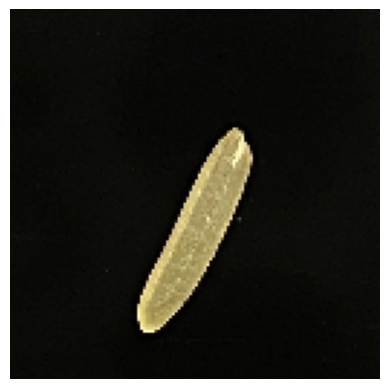

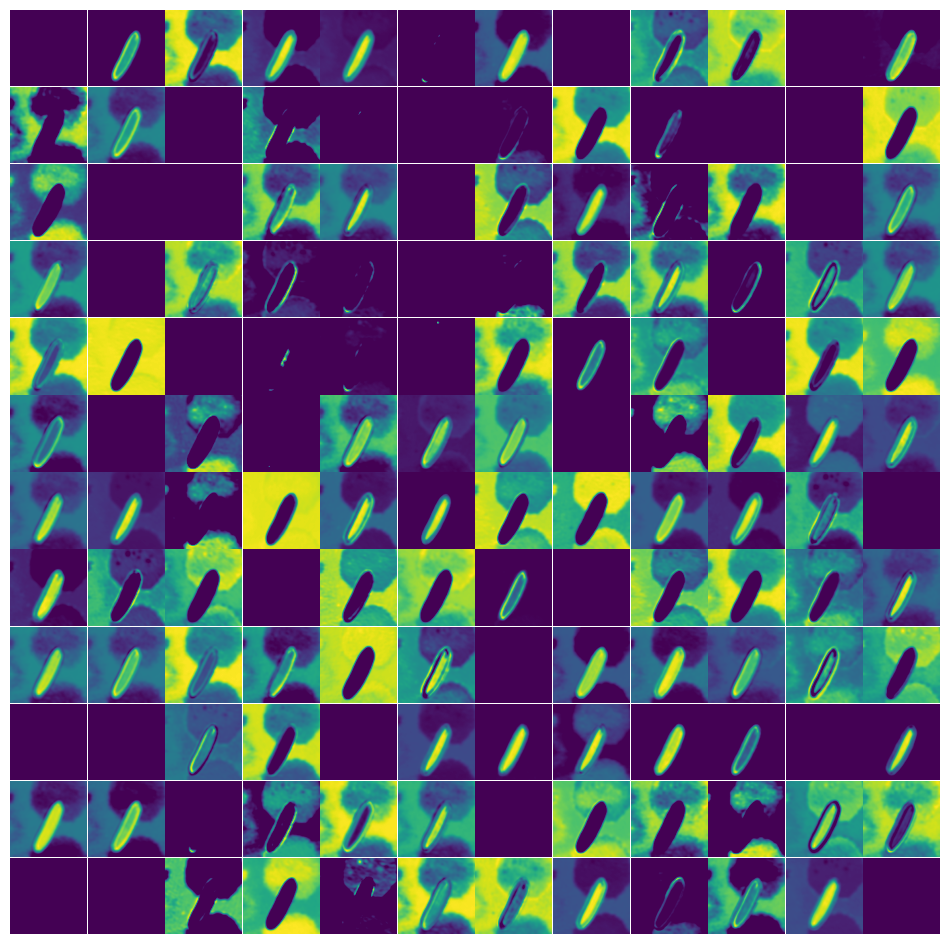

In [15]:
import matplotlib.pyplot as plt
import numpy as np

img = tf.keras.preprocessing.image.load_img("/home/forvest/projects/mahdi_amin/vision/classification/rice/data/2_Bashmoti/DeshiBashmoti_2_226.jpg", target_size = (image_height, image_width))
plt.imshow(img)
plt.axis('off')
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)

feature = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer("dropout_4").output)
extracted_feature = feature.predict(x)

imgs = extracted_feature[0,:,:]
plt.figure(figsize=(12,12))
for n in range(12*12):
    ax = plt.subplot(12,12,n+1)
    plt.imshow(imgs[:,:,n])
    plt.axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.01)

{
  "data": {
    "active_cryptocurrencies": 15025,
    "upcoming_icos": 0,
    "ongoing_icos": 49,
    "ended_icos": 3376,
    "markets": 1170,
    "total_market_cap": {
      "btc": 36879834.1618584,
      "eth": 828907874.833443,
      "ltc": 35527446002.0395,
    },
    "total_volume": {
      "btc": 1377525.96509316,
      "eth": 30961151.1603316,
      "ltc": 1327011914.5999,
    },
    "market_cap_percentage": {
      "btc": 53.5221522780442,
      "eth": 14.504395841117,
      "usdt": 5.3832433549393,
    },
    "market_cap_change_percentage_24h_usd": -3.97395612107443,
    "updated_at": 1723457885
  }
}